# Final Project - Exploratory Data Analysis
- Course: AAI-511-Neural Networks
- Institution: University of San Diego
- Professor: Kahila Mokhtari Jadid
- Group 4 Members: 
    * Lucas Young
    * Titouan Margret
    * Juan Pablo Triana Martinez

This notebook has the intention to go through the `final_proj_data` folder inside `data` folder, and do the following:
1. Create a class called `MidiPreprocesser` that would do the following
    - Receive a `Path` file from `pathlib` module where all the composer's data is located
    - Using `mido` module, read the files and retrieve all the info.
    - Retrieve the piano roll 2D representation per midi file.

We have also gotten all of the midi file theory info from this video, which we referenced for the understanding on the code that retrieve the 2D pinao roll representation per midi file: https://www.youtube.com/watch?v=P27ml4M3V7A

In [1]:
#Import necessary modules
import os
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# Data path file
curr_path = Path.cwd()
data_path = curr_path.parent / "data" / "final_proj_data"

if data_path.exists():
    print("Valid path to use to retreive midi files information")
else:
    print("Run appropiate code to retrieve the dataset")

Valid path to use to retreive midi files information


In [3]:
from mido import MidiFile
from tqdm import tqdm

class MidiPreprocesser:
    '''
    Class that would process all files found
    inside the final_proj_data folder and retrieve
    all the midi info for each of the files

    Args:
        data_path : Path from pathlib where data folder is located.

    Returns:
        midi_object: will see :)

    Example:
        midipreprocesser = MidiPreprocesser(data_path = set_path)
        midiobj = midipreprocesser.get_midi_info()
    '''

    def __init__(self, data_path:Path):
        self.data_path = data_path
    
    def get_midi_info(self):
        midis = []
        for root, dirs, files in tqdm(self.data_path.walk(), desc="Reading composers.."):
            count = 0
            for file in tqdm(files, desc=f"Reading_{root.stem} files...", total=len(files)):
                if file.endswith(".mid"):
                    try:
                        midis.append((root.stem + "_" + str(count), MidiFile(Path(root) / file)))
                        count += 1
                    except:
                        print(f"{file} cannot be read, is skipped")
                        continue
        return midis

In [4]:
midipreprocesser = MidiPreprocesser(data_path = data_path)
midiobj = midipreprocesser.get_midi_info()

Reading_final_proj_data files...: 0it [00:00, ?it/s]
Reading_Mozart files...: 100%|██████████| 925/925 [00:23<00:00, 39.19it/s]
Reading composers..: 2it [00:23, 11.81s/it]

K281 Piano Sonata n03 3mov.mid cannot be read, is skipped


Reading_Chopin files...: 100%|██████████| 257/257 [00:20<00:00, 12.36it/s]
Reading composers..: 3it [00:44, 15.55s/it]

Anhang 14-3.mid cannot be read, is skipped


Reading_Bach files...: 100%|██████████| 136/136 [00:05<00:00, 26.36it/s]
Reading composers..: 5it [01:14, 14.95s/it]


In [5]:
print(midiobj[0][0])
print(midiobj[0][1])

Mozart_0
MidiFile(type=1, ticks_per_beat=1024, tracks=[
  MidiTrack([
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='Am', time=0),
    MetaMessage('set_tempo', tempo=681818, time=0),
    MetaMessage('end_of_track', time=45056)]),
  MidiTrack([
    MetaMessage('track_name', name='Instrument 1', time=0),
    Message('note_on', channel=0, note=69, velocity=96, time=3072),
    Message('note_off', channel=0, note=69, velocity=0, time=1024),
    Message('note_on', channel=0, note=69, velocity=96, time=0),
    Message('note_off', channel=0, note=69, velocity=0, time=512),
    Message('note_on', channel=0, note=71, velocity=96, time=0),
    Message('note_off', channel=0, note=71, velocity=0, time=512),
    Message('note_on', channel=0, note=72, velocity=96, time=0),
    Message('note_off', channel=0, note=72, velocity=0, time=1024),
    Message('note_on', channel=0, note=71, veloci

### Midi file metadata

There are indeed a couple of midi files metadata that we are gonna use to create our 2D piano roll
- `set_tempo`: In MIDI, tempo refers to the **period** in $\mu_{s}(microseconds)/beat$. Normally we deal with the following:
    - 500,000 or 0.5 $\frac{s}{beat}$. Which means an event frequency of $2 Hz$
    - 1000,000 or 1 $\frac{s}{beat}$. Which means an event frequency of $1 Hz$

Using Nyquist-Shannon Sampling Theorem, we are converting from a MIDI file -> Piano roll based on symbolic representation using $f_(event)$. This means we need a minimum fs around 4 or 2 Hz to represent **Changes of events, NOT pitch frequency, which is what we want**. To settle things, we would use $fs = 10$.

Now what is fs? this is frequency sample. Let's do an example:
* Suppose we have a track of a total of 250 seconds.
* With an $fs = 10$, this means that my discretized tensor would have an axis of length 2500.
* And so on, so on.

NOW, what we want to capture is a 3D tensor that would be the following per MIDI file:
* `(128 * Discretized_time)`: These contain the following:
    - First Axis: **All 128 possible Octave pitch notes**, values with pitch range note value from 0 to 127.
    - Second Axis: **Time the track took**, values with ranges from 0 to $f_{s} * time$.
    - Values first Axis: `torch.tensor[pitch, t] = velocity`, at each **time step**, we would assign for the specific **pitch** axis, the value of velocity

Time here! how do we define it, with the following formula (tempo is in miliseconds, so we need to divide it by 1000000 to make it seconds).

$$
seconds  = \frac{ticks}{ticks per beat} * \frac{tempo}{1,000,000}
$$

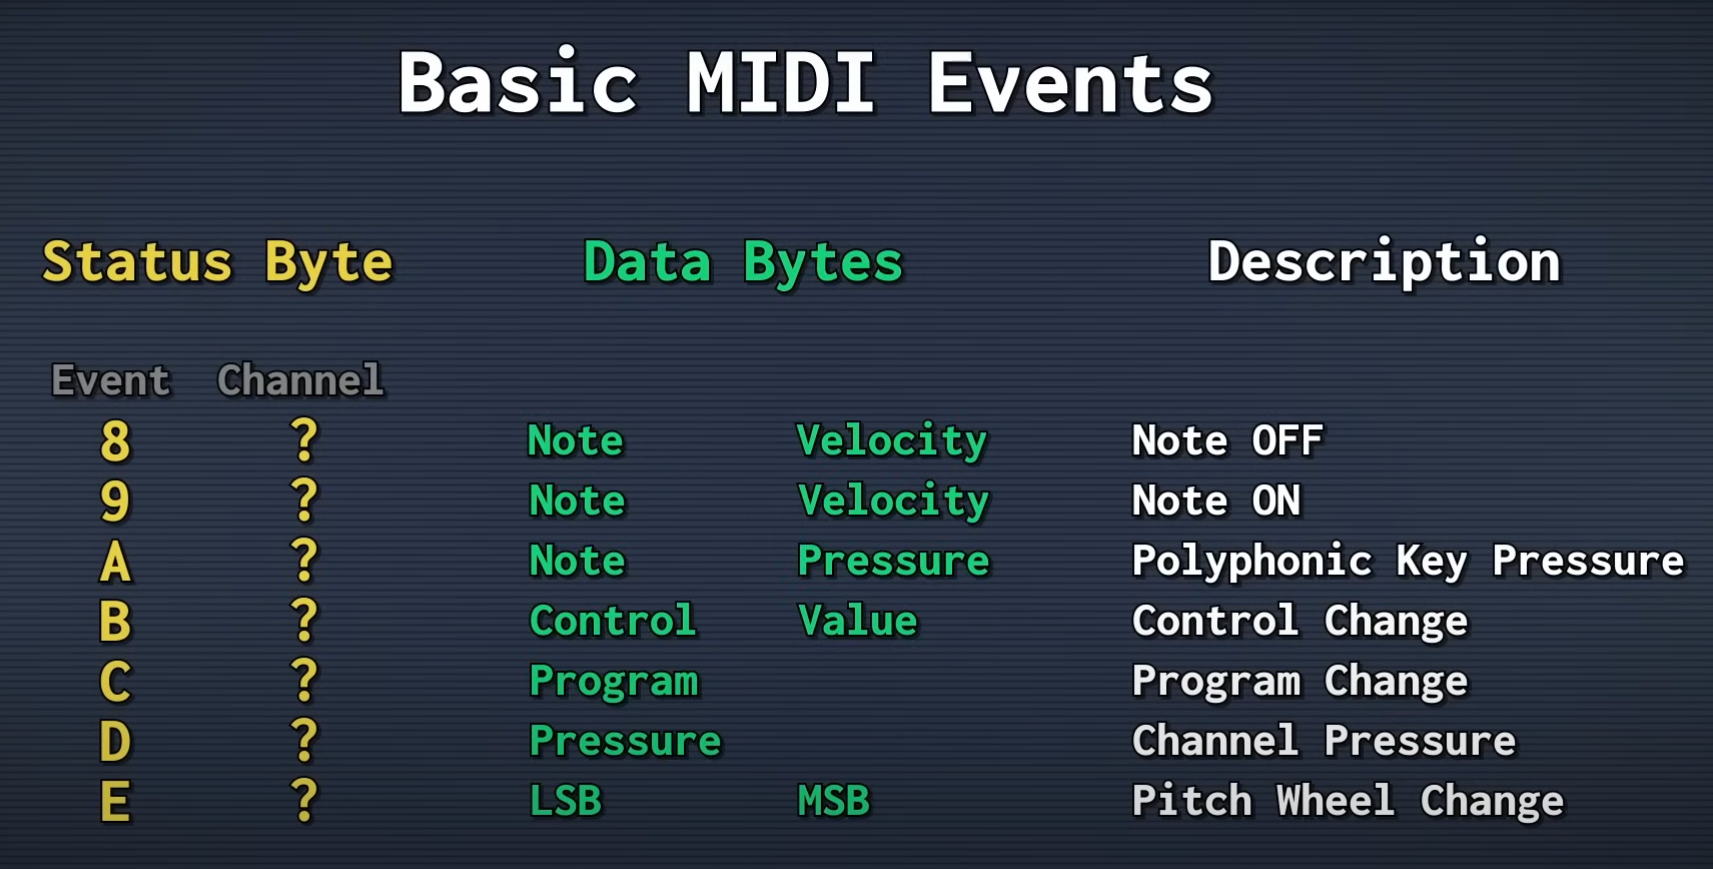

In [6]:
from mido import MidiFile
from typing import Union, Tuple
import numpy as np

class MidiToNumpy:
    '''
    Class that would process one Midifile
    object, and do the following:
        - Set the midi ticks per beat
        - Set the fs to discretize Midi information -> Discrete symbolic numpy array
        - Iterate across all tracks and find events of the following:
            * set_tempo
            * note_on
            * note_off
        - create a numpy array of zeroes of size (128, T) 

        Args:
            file: Midifile containing all tracks to use.
            tempo: Integer representing default tempo time for a midi file in microseconds/beat.
            values can be 500,000 or 1000,000
            fs: Integer representing discretize frequency sample time for evets, default = 10
        
        Returns:
            np_piano: np.ndarray of size (128, T) representation
            of the midi file

        Example:
            midi_np_processor = MidiToNumpy(file = midi_file,
                                default_tempo = 500000, fs = 10)
            np_midi = midi_np_processor.get_np_array()
    '''

    def __init__(self, file:MidiFile, default_tempo:int = 500000, fs:int = 10) -> None:
        self.file = file
        self.ticks_per_beat = file.ticks_per_beat
        self.tempo = default_tempo
        self.fs = fs

    def _calculate_seconds(self, ticks:int) -> Union[float, int]:
        return (ticks / self.ticks_per_beat) * (self.tempo / 1_000_000)

    def _get_np_array_info(self) -> Tuple[float, float, int, int]:
        # List to hold note start and end info
        notes = []

        for track in self.file.tracks:
            time_ticks = 0
            ongoing_notes = {}
            for msg in track:
                time_ticks += msg.time
                if msg.type == 'set_tempo':
                    self.tempo = msg.tempo
                elif msg.type == 'note_on' and msg.velocity > 0:
                    # Start note
                    ongoing_notes[msg.note] = (time_ticks, msg.note, msg.velocity)
                elif (msg.type == 'note_off') or (msg.type == 'note_on' and msg.velocity == 0):
                    # End note
                    if msg.note in ongoing_notes:
                        start_time_ticks, note, note_velocity = ongoing_notes.pop(msg.note)
                        
                        #Convert tick times to seconds
                        start_time = self._calculate_seconds(ticks=start_time_ticks)
                        time = self._calculate_seconds(ticks=time_ticks)
                        notes.append((start_time, time, note, note_velocity))
        return notes

    def get_np_array(self) -> np.ndarray[int, float]:
        notes_info = self._get_np_array_info()

        #Let's get end time to create he np.ndarray
        _ , final_time , _ , _ = notes_info[-1]
        np_array = np.zeros(shape = (128, int(np.floor(final_time)*self.fs)), dtype=np.float32)

        for start_time, time, note, note_velocity in tqdm(notes_info, desc=f"Creating Piano roll: {self.file.filename.stem}", total=len(notes_info)):
            start_time_clipped = int(np.round(start_time*self.fs))
            time_clipped = int(np.round(time*self.fs))
            np_array[note, start_time_clipped:time_clipped] = note_velocity

        return np_array


[(0.0, 0.625, 73, 96), (0.625, 1.25, 74, 96), (1.25, 1.875, 76, 96), (1.875, 2.5, 76, 96), (2.5, 3.125, 74, 96)]


Creating Piano roll: 015403b_: 100%|██████████| 274/274 [00:00<00:00, 85578.92it/s]


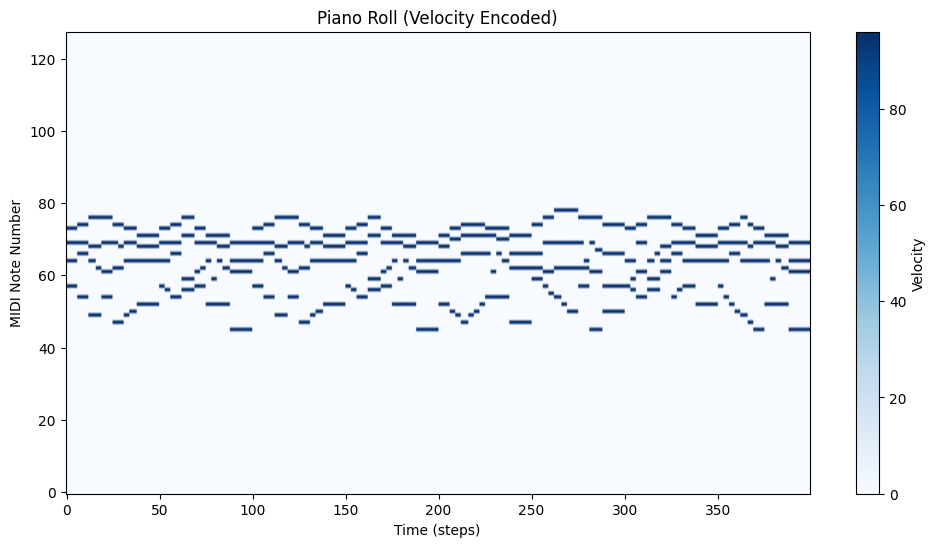

In [7]:
# With customized class
midi_np_processor = MidiToNumpy(file = midiobj[200][1],
                    default_tempo = 500000, fs = 10)
midi_info = midi_np_processor._get_np_array_info()

# Compare infos
print(midi_info[0:5])

np_midi = midi_np_processor.get_np_array()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.imshow(np_midi, aspect='auto', origin='lower', cmap='Blues')  # velocity as intensity
plt.xlabel("Time (steps)")
plt.ylabel("MIDI Note Number")
plt.title("Piano Roll (Velocity Encoded)")
plt.colorbar(label='Velocity')
plt.show()
